In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import scipy
import pickle
from sklearn.metrics import pairwise_distances
from sklearn import preprocessing
import random
from collections import Counter
from tqdm.notebook import tqdm

%matplotlib inline

Read in the data from the unmodified mRNA experiment and sort by total reads.

In [2]:
df = pd.read_csv("../data/GSM3130435_egfp_unmod_1.csv")
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)

Check the distribution of read counts

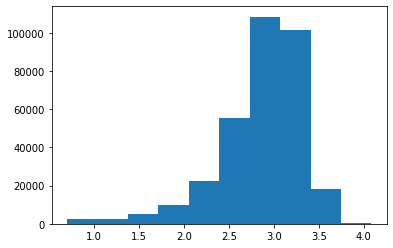

In [3]:
log_reads = np.log10(df['total_reads'])
plt.hist(log_reads)
plt.show()

The authors chose to only use the top 280,000 sequences. This corresponds to sequences with at least 267 reads.

In [4]:
df.loc[280_000,'total_reads']

267.0

Subset for top 280,000 sequences and identify sequences with uAUGs.

In [5]:
df_subset = df.iloc[:280000]

# Create column that identifies upstream AUGs
df_subset = df_subset.assign(uAUG=df_subset['utr'].str.contains("ATG"))

Check that all UTR sequences are 50 bp long

In [6]:
lengths = df_subset['utr'].map(len)
lengths.value_counts()

50    280000
Name: utr, dtype: int64

Check that no UTRs are repeated.

In [7]:
sum(df_subset.duplicated(subset='utr'))

0

Check distrubution of mean ribosome load.

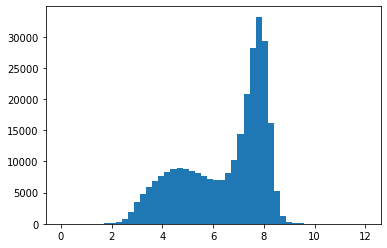

In [8]:
plt.hist(df_subset['rl'], bins=50)
plt.show()

Look at ribosome load distribution for uAUG and no uAUG separately

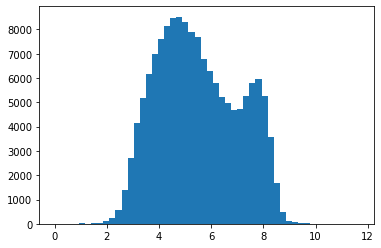

In [9]:
plt.hist(df_subset.loc[df_subset['uAUG'], 'rl'], bins=50)
plt.show()

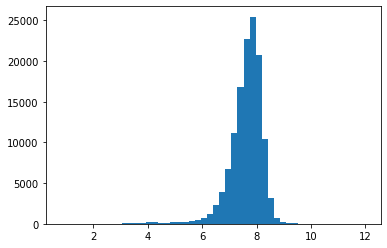

In [10]:
plt.hist(df_subset.loc[~df_subset['uAUG'], 'rl'], bins=50)
plt.show()

Split uAUG sequences based on whether the uAUG is in frame or not. The start codon is immediately after the random 50 bp 5' UTR, so check each 3 bp sequence for ATG starting at index 2. The base before the 50 bp random region is an A, so also check for any sequence that starts with TG.

In [11]:
def uAUG_in_frame(seq):
  if seq[0:2] == "TG":
    return True
  for i in range(2, 50, 3):
    if seq[i:i + 3] == 'ATG':
      return True
  return False

print(uAUG_in_frame('CGATGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG'))
print(uAUG_in_frame('TGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG'))

uAUG = df_subset.loc[df_subset['uAUG']]
uAUG['in_frame'] = uAUG['utr'].apply(uAUG_in_frame)

True
True


C:\Users\nmateyko\AppData\Local\Temp\ipykernel_26076\3199174694.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uAUG['in_frame'] = uAUG['utr'].apply(uAUG_in_frame)


Distribution of sequences with in-frame uAUG:

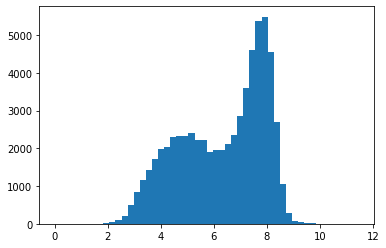

In [12]:
plt.hist(uAUG.loc[uAUG['in_frame'], 'rl'], bins=50)
plt.show()

Distribution of sequences with out of frame uAUG:

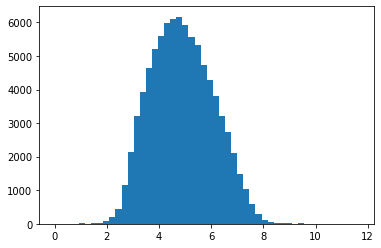

In [13]:
plt.hist(uAUG.loc[~uAUG['in_frame'], 'rl'], bins=50)
plt.show()

uAUG in frame distribution is still bimodal. Split into sequences with and without uORF to see if this explains some of the lower MRL.

In [22]:
# Assumes input seq has an uAUG
def uORF(seq):
  if seq[0:2] == "TG":
    start = 2
  else:
    for i in range(2, 50, 3):
      if seq[i:i + 3] == 'ATG':
        start = i
  for i in range(start, 50, 3):
    if seq[i:i + 3] in ('TAA', 'TAG', 'TGA'):
      return True
  return False


print(uORF('CGATGGGGGGGTAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG')) # True
print(uORF('TGAGGTGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG')) # True
print(uORF('TGAGGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG')) # False

in_frame = uAUG.loc[uAUG['in_frame']]
in_frame['uORF'] = in_frame['utr'].apply(uORF)

True
True
False


C:\Users\nmateyko\AppData\Local\Temp\ipykernel_26076\82732165.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_frame['uORF'] = in_frame['utr'].apply(uORF)


Sequences with in-frame uAUG that creates an uORF:

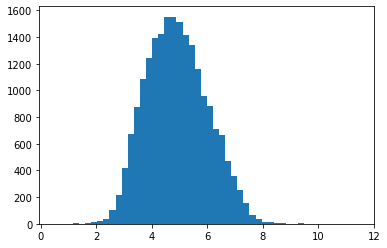

In [20]:
plt.hist(in_frame.loc[in_frame['uORF'], 'rl'], bins=50)
plt.show()

Sequences with in-frame uAUG that doesn't create an uORF:

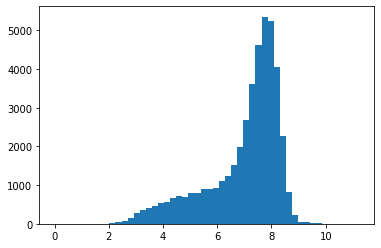

In [23]:
plt.hist(in_frame.loc[~in_frame['uORF'], 'rl'], bins=50)
plt.show()

Check the nucleotide content distributions for the UTR sequences.

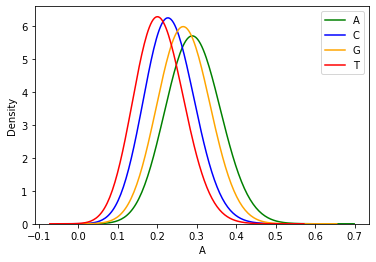

In [25]:
bases = ['A', 'C', 'G', 'T']
def char_count(seq, chars):
    return [seq.count(c)/len(seq) for c in chars]

bp_freqs = np.array([char_count(seq, bases) for seq in df_subset['utr']])
bp_freqs_df = pd.DataFrame.from_records(bp_freqs, columns=bases)

sns.kdeplot(data=bp_freqs_df, x="A", color='green', label="A", bw_adjust=5)
sns.kdeplot(data=bp_freqs_df, x="C", color='blue', label="C", bw_adjust=5)
sns.kdeplot(data=bp_freqs_df, x="G", color='orange', label="G", bw_adjust=5)
sns.kdeplot(data=bp_freqs_df, x="T", color='red', label="T", bw_adjust=5)

plt.legend() 
plt.show()

Check the average nucleotide content of all UTR sequences.

In [26]:
bp_freqs_df.sum()/280000

A    0.292706
C    0.232578
G    0.268041
T    0.206674
dtype: float64

Check correlation between GC content and mean ribosome load.

In [27]:
def GC_content(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

# print(GC_content("ACTCCG")) # 2/3
# print(GC_content("AATTA")) # 0
GC = [GC_content(seq) for seq in df_subset['utr']]


<AxesSubplot:ylabel='rl'>

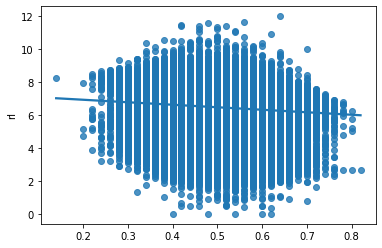

In [28]:
sns.regplot(x=GC, y=df_subset['rl'], ci=None)

Split into test and train. The authors chose the 20,000 sequences with highest number of reads as the test set.

In [29]:
# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df_subset.iloc[:20000]
e_train = df_subset.iloc[20000:]

Check that uAUGs are represented equally in the test and train sets.

In [30]:
print(f"Percent uAUG in data: {sum(df_subset['uAUG'])/df_subset.shape[0]}")
print(f"Percent uAUG in train: {sum(e_train['uAUG'])/e_train.shape[0]}")
print(f"Percent uAUG in test: {sum(e_test['uAUG'])/e_test.shape[0]}")

Percent uAUG in data: 0.5394964285714285
Percent uAUG in train: 0.5272038461538462
Percent uAUG in test: 0.6993


It looks like the test set that the authors used is enriched for sequences with uAUGs. Here's what we would expect:

In [31]:
random_seqs = ["".join(random.choices(['A', 'T', 'G', 'C'], k=50)) for i in range(100000)]
sum(['ATG' in seq for seq in random_seqs])/len(random_seqs)

0.5431

The authors included this plot in the supplement: ![](../images/reads_vs_performance.png)

The model seems to perform much worse on the sequences with no uAUG. Look at the proportion of uAUG-containing sequences in each of these bins:

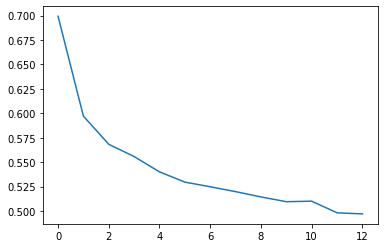

In [32]:
uAUG_freq = [sum(df_subset.loc[i:i + 20000,'uAUG'])/20000 for i in range(0, 260000, 20000)]
plt.plot(uAUG_freq)
plt.show()

Compare replicates. Keep top 120k UTRs with most reads (similar cutoff to rep 1)

In [33]:
df2 = pd.read_csv("../data/GSM3130436_egfp_unmod_2.csv")
df2.sort_values('total', inplace=True, ascending=False)
df2.reset_index(inplace=True, drop=True)
df_subset2 = df2.iloc[:120000]
df2.loc[120_000,'total']

267.0

Inner join the replicates on the UTR column to find sequences in both reps.

C:\Users\nmateyko\AppData\Local\Temp\ipykernel_3640\1999769913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset2['utr'] = df_subset2['utr'].astype(str)


0


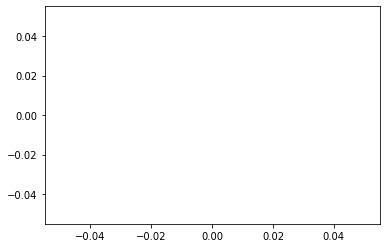

In [34]:
df_subset['utr'] = df_subset['utr'].astype(str)
df_subset2['utr'] = df_subset2['utr'].astype(str)
merged = pd.merge(df_subset, df_subset2, on='utr', suffixes=("_1", "_2"))
print(len(merged))
plt.scatter(merged['rl_1'], merged['rl_2'], alpha=0.1)
plt.show()

In [ ]:
seqs = df_subset.loc[:100, 'utr']
sum(sum(df_subset2['utr'].str.contains(seq)) for seq in seqs)

Check to see if parts of the train UTR sequences are found in the test set due to PCR chimeras. If this is a major problem, the distribution of pairwise hamming distances between the train and test sets should differ from the expected binomial distribution.

In [ ]:
# Split strings into arrays of chars
def split_seqs(seqs):  
    return np.array([np.fromiter(seq, (np.compat.unicode,1)) for seq in seqs])

e_test_split = split_seqs(e_test['utr'])
e_train_split = split_seqs(e_train['utr'])

# check that only A, C, G, T present in UTRs
uniques = np.unique(e_test_split)
print(uniques)
print(np.unique(e_train_split))

# Convert characters to ints so that sklearn pairwise_distances can be used,
# which is much faster than my own hamming distance implementation
test_encoded = np.searchsorted(uniques, e_test_split)
train_encoded = np.searchsorted(uniques, e_train_split)

# Calculate pairwise distances between train and test
dists = pairwise_distances(X=train_encoded[:5000], Y=test_encoded[:5000], metric='hamming')

`pairwise_distances` gives a proportion instead of the actual hamming distance, so multiply by 50 to get the hamming distance. 

In [ ]:
flat = dists.flatten()
flat = np.rint(flat * 50)
plt.hist(flat, bins=range(51))
plt.show()

Count the frequency of each hamming distance and convert to a pmf

In [ ]:
counts = Counter(flat)
counts_list = counts.items()
freqs = np.zeros(51)
for count in counts_list:
    freqs[int(count[0])] = count[1]
total = sum(counts.values())
freqs = freqs/total

Compare observed pmf to the expected binomial pmf. The binomial assumes that all bases are equally likely, which isn't quite true (see above).

In [ ]:
plt.bar(range(51), freqs, color='red', alpha=0.5)
plt.bar(range(51), scipy.stats.binom.pmf(range(51), 50, 0.75), color='blue', alpha=0.5)
plt.show()

Simulate what it would look like if test and train were exactly the same.

In [ ]:
rand_sample = [random.choices(range(4), k=50) for i in range(5000)]
dists = pairwise_distances(X=rand_sample, Y=rand_sample, metric='hamming')
flat = dists.flatten()
flat = np.rint(flat * 50)
counts = Counter(flat)
counts_list = counts.items()
freqs = np.zeros(51)
for count in counts_list:
    freqs[int(count[0])] = count[1]
total = sum(counts.values())
freqs = freqs/total
plt.bar(range(51), freqs, color='red', alpha=0.5)
plt.bar(range(51), scipy.stats.binom.pmf(range(51), 50, 0.75), color='blue', alpha=0.5)
plt.show()

Probably not the best way to check for test/train violations!

Instead, manually inspect the test/train pairs with the lowest hamming distance to see if PCR chimeras seem to be an issue.

In [ ]:
dists = pairwise_distances(X=train_encoded[:50000], Y=test_encoded[:10000], metric='hamming')

In [ ]:
np.amin(dists)*50

In [ ]:
train_ids, test_ids = np.where(dists * 50 == 1)
for i in zip(train_ids, test_ids):
    print("".join(e_train_split[i[0]]))
    print("".join(e_test_split[i[1]]))
    print("\n")

In [ ]:
train_ids, test_ids = np.where(dists * 50 == 17)
for i in zip(train_ids, test_ids):
    print("".join(e_train_split[i[0]]))
    print("".join(e_test_split[i[1]]))
    print("\n")

In [ ]:
del dists

In [ ]:
def max_run(seqs1, seqs2, min_len):
    rows = len(seqs1)
    cols = len(seqs2)
    seq_len = len(seqs1[0])
    a = (seqs1[:, None, :] == seqs2[None, :, :]).reshape(cols * rows, seq_len)
    m,n = a.shape
    A = np.zeros((m,n+2), dtype=bool)
    A[:m,1:-1] = a

    dA = np.diff(A)
    nz = np.nonzero(dA)
    start = (nz[0][::2], nz[1][::2])
    end = (nz[0][1::2], nz[1][1::2])

    run_lengths = end[1]-start[1]
    argmax_run = np.where(run_lengths >= min_len)
    row = start[0][argmax_run]
    return (list(seqs1[row // cols]), list(seqs2[row % cols]), list(run_lengths[argmax_run]))

def find_long_runs(train, test, split_size, min_len):
    runs_train = []
    runs_test = []
    lengths = []
    for i in tqdm(range(0, len(train), split_size)):
        for j in range(0, len(test), split_size):
            seqs1 = train[i:i + split_size]
            seqs2 = test[j:j + split_size]
            res = max_run(seqs1, seqs2, min_len)
            runs_train += res[0]
            runs_test += res[1]
            lengths += res[2]
            for seq1, seq2 in zip(res[0], res[1]):
                print(f"{''.join(seq1)}\n{''.join(seq2)}\n\n")
    return (runs_train, runs_test, lengths)

In [ ]:
long_runs = find_long_runs(e_train_split, e_test_split, 4000, 15)

In [ ]:
train_shifted = np.roll(e_train_split, -1, 1)
long_runs_train_shift = find_long_runs(train_shifted, e_test_split, 4000, 15)
del train_shifted

In [ ]:
train_random = np.array([random.choices(['A', 'T', 'G', 'C'], k=50) for i in range(260000)])
test_random = np.array([random.choices(['A', 'T', 'G', 'C'], k=50) for i in range(20000)])
long_runs_random = find_long_runs(train_random, test_random, 4000, 15)

In [ ]:
print(len(long_runs[0]))
print(len(long_runs_train_shift[0]))
print(len(long_runs_random[0]))

In [ ]:
plt.hist(long_runs[2], bins=range(15,51))

In [ ]:
plt.hist(long_runs_random[2], bins=range(15,51))

In [ ]:
plt.hist(long_runs_train_shift[2], bins=range(15,51))

In [ ]:
pickle.dump(long_runs, open("long_runs.pkl", "wb"))
pickle.dump(long_runs_random, open("long_runs_random.pkl", "wb"))
pickle.dump(long_runs_train_shift, open("long_runs_train_shift.pkl", "wb"))

In [ ]:
## check for correlation between read number and GC content ##